In [1]:
import torch
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')
paths = {
    "MNIST_30000" : "/content/drive/MyDrive/ColabNotebooks/TFG/datos/MNIST_30000.zip",
    "MNIST_70000" : "/content/drive/MyDrive/ColabNotebooks/TFG/datos/MNIST_70000.zip",
    "CELEBA_30000" : "/content/drive/MyDrive/ColabNotebooks/TFG/datos/CELEBA_30000.zip",
    "CELEBA_70000" : "/content/drive/MyDrive/ColabNotebooks/TFG/datos/CELEBA_70000.zip"
}

#Cambiar directorio donde guardar los resultados
dirs = {
    "mnist_30000" : './datasets/MNIST_30000/',
    "mnist_70000" : './datasets/MNIST_70000/',
    "celeba_30000" : './datasets/CELEBA_30000/',
    "celeba_70000" : './datasets/CELEBA_70000/',
    "results_folder" : "/content/drive/MyDrive/ColabNotebooks/TFG/checkpoints/WGAN/CELEBA_70000/"
}

path = paths["CELEBA_70000"]

Mounted at /content/drive


In [3]:
!mkdir datasets
%cd datasets
%cp "{path}" .
!unzip -q CELEBA_70000.zip
%rm CELEBA_70000.zip
%cd ..

/content/datasets
/content


In [4]:
!nvidia-smi
%load_ext tensorboard

Tue Jun 27 07:55:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!rm -rf ./logs/

In [6]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            #Input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), #16 x 16
            self._block(features_d*2, features_d*4, 4, 2, 1),#8 x 8
            self._block(features_d*4, features_d*8, 4, 2, 1),#4 x 4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), #1x1

        )
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            #Input: N x z_dim x 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1), #8x8
            self._block(features_g*8, features_g*4, 4, 2, 1), #16 x 16
            self._block(features_g*4, features_g*2, 4, 2, 1), # 32x32
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ), # 64x64
            nn.Tanh(), #[-1, 1]
        )
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias = False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.gen(x)

In [8]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [9]:
def test():
    N, in_channels, H, W, = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    critic = Critic(in_channels, 8)
    initialize_weights(critic)
    assert critic(x).shape == (N, 1, 1, 1)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")
test()

Success


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transform
import torchvision.utils as torch_utils
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import os as os
from PIL import Image
from natsort import natsorted
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from scipy.linalg import sqrtm
from tqdm import tqdm
import numpy as np
import zipfile
import gc
import time
from scipy.stats import entropy
import random

In [11]:
from torchvision.models.inception import inception_v3
import copy

class GAN_Evaluator(object):
    def __init__(self, device, num_images_real, num_images_fake, IS_splits) -> None:
        self.min_resolution = 75
        self.device = device

        if device.type == 'cuda':
            self.dtype = torch.cuda.FloatTensor
        else:
            if torch.cuda.is_available():
                print("You have cuda device, try setting cuda=True for accelearte the training")
            self.dtype = torch.FloatTensor

        self.inception_encoder = inception_v3(weights="DEFAULT", transform_input=False).type(self.dtype)
        self.inception_classifier = copy.deepcopy(self.inception_encoder.fc)
        self.inception_classifier.eval()
        self.inception_encoder.fc = torch.nn.Identity()
        self.inception_encoder.eval()
        self.upsample = torch.nn.Upsample(size=(299, 299),
            mode='bilinear').type(self.dtype)

        self.num_images_real = num_images_real
        self.num_images_fake = num_images_fake
        self.activation_vec_real = np.empty((self.num_images_real, 2048))
        self.activation_vec_fake = np.empty((self.num_images_fake, 2048))
        self.prediction_vec_fake = np.empty((self.num_images_fake, 1000))
        self.vec_real_pointer = 0
        self.vec_fake_pointer = 0

        self.IS_splits = IS_splits

    def get_real_activations(self, n):
      return self.activation_vec_real[:n]

    def get_fake_activations(self, n):
      return self.activation_vec_fake[:n]

    def normalize(self, image, dynamic_range = [0, 1]):
        #assert len(dynamic_range) == 2

        x1, x2 = image.min(), image.max()
        y1, y2 = dynamic_range[0], dynamic_range[1]

        slope = (y2 - y1) / (x2 - x1)
        offset = (y1 * x2 - y2 * x1) / (x2 - x1)

        image = image * slope + offset
        image = image.clip(y1, y2)
        return image

    def get_distance(self, v1, v2):
      return np.linalg.norm(v1-v2)

    def get_radius(self, v, points):
      dist = np.linalg.norm(np.array([v] * points.shape[0]) - points, axis = 1)
      dist = sorted(dist)
      return dist

    def get_manifold(self, points, k=3):
      radius = np.zeros([self.vec_fake_pointer])
      for i in range(self.vec_fake_pointer):
        radius[i] = self.get_radius(points[i], points)[k]
      return {
          "radius": radius,
          "len": points.shape[0],
          "points": points
      }

    def in_manifold(self, activations, manifold):
        for i in range(manifold["len"]):
            if np.linalg.norm(activations-manifold["points"][i]) <= manifold["radius"][i]:
                return 1
        return 0

    def getPrecRecall(self):
      manifold_real = self.get_manifold(self.activation_vec_real[:self.vec_fake_pointer])
      manifold_fake = self.get_manifold(self.activation_vec_fake[:self.vec_fake_pointer])
      precision = 0
      for i in range(self.vec_fake_pointer):
        precision += self.in_manifold(self.activation_vec_fake[i], manifold_real)
      precision = precision / self.vec_fake_pointer

      recall = 0
      for i in range(self.vec_fake_pointer):
        recall += self.in_manifold(self.activation_vec_real[i], manifold_fake)
      recall = recall / self.vec_fake_pointer

      return precision, recall


    def fill_real_image_batch(self, real_batch):
        transforms_norm = transform.Compose([
                transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        batch_size = real_batch.shape[0]
        real_batch = self.normalize(real_batch)
        real_batch = real_batch.type(torch.FloatTensor).to(self.device)

        _, C, H, W = real_batch.shape
        if H < self.min_resolution or W < self.min_resolution:
            real_batch = self.upsample(real_batch)

        if C == 1:
            transforms = transform.Compose([
                transform.Lambda(lambda x: torch.cat([x, x, x], 1)),
            ])
            real_batch = transforms(real_batch)

        # Get activations.
        with torch.no_grad():
            real_batch = transforms_norm(real_batch)
            activations_real = self.inception_encoder(real_batch)
        self.activation_vec_real[self.vec_real_pointer:self.vec_real_pointer +
                                 batch_size] = activations_real.cpu().numpy()
        self.vec_real_pointer += batch_size

        return

    def fill_fake_image_batch(self, fake_batch, compute):
        batch_size = fake_batch.shape[0]
        fake_batch = self.normalize(fake_batch)
        fake_batch = fake_batch.type(torch.FloatTensor).to(self.device)

        _, C, H, W = fake_batch.shape
        if H < self.min_resolution or W < self.min_resolution:
            fake_batch = self.upsample(fake_batch)

        if C == 1:
            transforms = transform.Compose([
                transform.Lambda(lambda x: torch.cat([x, x, x], 1)),
            ])
            fake_batch = transforms(fake_batch)

        with torch.no_grad():
            activations_fake = self.inception_encoder(fake_batch)
            preds_fake = self.inception_classifier(activations_fake)
            probs_fake = torch.nn.functional.softmax(preds_fake,
                                                    dim=1).data.cpu().numpy()
        self.activation_vec_fake[self.vec_fake_pointer:self.vec_fake_pointer +
                                 batch_size] = activations_fake.cpu().numpy()
        self.prediction_vec_fake[self.vec_fake_pointer:self.vec_fake_pointer +
                                 batch_size] = probs_fake
        self.vec_fake_pointer += batch_size

        if compute:
          IS_mean, IS_std = self.getInceptionScore()
          Fid = self.getFrechetInceptionDistance()
          return IS_mean, IS_std, Fid
        return

    def clear_fake_images(self):
        self.activation_vec_fake = np.empty((self.num_images_fake, 2048))
        self.prediction_vec_fake = np.empty((self.num_images_fake, 1000))
        self.vec_fake_pointer = 0
        return

    def clear_real_images(self):
        self.activation_vec_real = np.empty((self.num_images_real, 2048))
        self.vec_real_pointer = 0
        return

    def fill_fake_image_full(self, fake_images_loader):
        self.clear_fake_images()
        for fake_batch in tqdm(fake_images_loader):
            self.fill_fake_image_batch(fake_batch)

        Is_mean, Is_std = self.getInceptionScore()
        Fid = self.getFrechetInceptionDistance()

        return Is_mean, Is_std, Fid

    def fill_real_image_full(self, real_images_loader):
        self.clear_real_images()
        for real_batch in tqdm(real_images_loader):
            self.fill_real_image_batch(real_batch)

        return

    def getInceptionScore(self):
        split_scores = []

        for k in range(self.IS_splits):
            data = self.prediction_vec_fake[:self.vec_fake_pointer]
            part = data[k * (self.vec_fake_pointer // self.IS_splits): (k+1) * (self.vec_fake_pointer // self.IS_splits), :]
            py = np.mean(part, axis=0)
            scores = []
            for i in range(part.shape[0]):
                pyx = part[i, :]
                scores.append(entropy(pyx, py))

            split_scores.append(np.exp(np.mean(scores)))

        return np.mean(split_scores), np.std(split_scores)

    def getFrechetInceptionDistance(self):
        real_activations = self.activation_vec_real[:self.vec_real_pointer]
        fake_activations = self.activation_vec_fake[:self.vec_fake_pointer]

        mu1, sigma1 = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
        mu2, sigma2 = fake_activations.mean(axis=0), np.cov(fake_activations, rowvar=False)

        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

        return fid


In [12]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        #image = Image.open(img_loc).convert("RGB")
        image = Image.open(img_loc)
        if self.transform:
          image = self.transform(image)
        return image

In [13]:
from pickle import FALSE
import cv2 as cv2
class GAN_utils(object):
  def __init__(self, epochs, path, dataset):
    #Lists for storage Losses, FIDs and Inception Scores
    self.InceptionList, self.FIDList, self.generatorLoss, self.discriminatorLoss, self.epochs_time  = [], [], [], [], []
    self.gridImages = []
    self.num_epochs = epochs
    self.precision, self.recall = [], []
    self.path = path
    self.dataset = dataset

  def getPrecision(self):
    return self.precision, self.recall
  def appendLosses(self, gen_loss, disc_loss):
    self.generatorLoss.append(gen_loss)
    self.discriminatorLoss.append(disc_loss)

  def appendPrecisionRecall(self, prec, recall):
    self.precision.append(prec)
    self.recall.append(recall)

  def appendInceptionScore(self, inception):
    self.InceptionList.append(inception)

  def apendFid(self, fid):
    self.FIDList.append(fid)

  def appendEpochTime(self, time):
    self.epochs_time.append(time)

  def getTotalTrainingTime(self):
    return sum(self.epochs_time)

  def appendImagesToGrid(self, img):
    self.gridImages.append(img)

  def PrecisionRecall(self):
    save_path = self.path + "PrecRecall2_chartt.png"
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(self.recall, self.precision)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    plt.savefig(save_path)

  def plotLossesChart(self):
    save_path = self.path + "losses_chartt.png"
    plt.figure(figsize=(10,5))
    plt.title("DCGAN Loss Chart")
    plt.plot(self.generatorLoss,label="Generator Loss")
    plt.plot(self.discriminatorLoss,label="Discriminator Loss")
    plt.xlabel("epochs")
    plt.ylabel("Losses")
    plt.legend()
    plt.savefig(save_path)
    plt.show()

  def plotFidIsChart(self):
    save_path = self.path + "FIDIS_chartt.png"
    epoch_list = list(range(0,self.num_epochs))
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(epoch_list, self.InceptionList, color='firebrick')
    ax.plot(epoch_list, self.InceptionList, color='firebrick')
    ax.set_ylabel('Inception Score (IS)')
    ax.set_xlabel('Epoch')
    ax.spines[['right', 'top']].set_visible(False)
    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(epoch_list, self.FIDList, color='firebrick')
    ax.plot(epoch_list, self.FIDList, color='firebrick')
    ax.set_ylabel('Frechet Inception Distance (FID)')
    ax.set_xlabel('Epoch')
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

  def getGeneratedImage(self, generator):
    gen.eval()
    with torch.no_grad():
      noise = torch.randn(1, Z_DIM, 1, 1).to(device)
      img = generator(noise)
    img = np.asarray(img.detach().cpu())
    img = np.squeeze(img, axis=0)
    img = np.transpose(img, (1, 2, 0))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    _, _, C = img.shape
    if C == 1:
      plt.imshow(img, cmap="gray")
    else:
      plt.imshow(img)

  def grid_animation(self, author):
    save_path = self.path + "grid_animation.gif"
    fig = plt.figure(figsize=(8,8))
    plt.axis('off')
    ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in self.gridImages]
    anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    plt.show()
    anim.save(save_path, dpi=80, writer=author)

  def startSeed(self, seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

  def plotDataLoader(self, dataloader):
    # Plot some training images
    real_batch = next(iter(loader))
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.title("Training Images")
    grid_images = torch_utils.make_grid(real_batch[:16].to(device).cpu(), normalize=True)
    grid_numpy = grid_images.numpy()
    grid_numpy2 = np.transpose(grid_numpy, (1, 2, 0))
    plt.imshow(grid_numpy2)

  def save_checkpoint(self, epoch, gen, opt_gen, disc, opt_disc, loss_gen, loss_disc):
    save_path = self.path + "epoch=" + str(round(epoch, 4)) + "%loss_disc=" + str(round(loss_disc.item(), 4)) + "%loss_gen=" + str(round(loss_gen.item(), 4)) + ".pt"
    torch.save({
        'epoch': epoch,
        'gen_state_dict': gen.state_dict(),
        'gen_optimizer_state_dict': opt_gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'disc_optimizer_state_dict': opt_disc.state_dict(),
        'gen_loss': loss_gen,
        'disc_loss':loss_disc
      }, save_path)

  def saveResults(self, actual_epoch):
    path_txt = self.path + "results_epoch=" + str(actual_epoch) + ".txt"
    with open(path_txt, 'w') as f:
      f.write("Model: WGAN  \n")
      f.write("Dataset: " + self.dataset + "\n")
      f.write("Epochs: " + str(actual_epoch) + "\n")
      f.write("Generator Losses: [")
      for i in self.generatorLoss:
        f.write(str(i) + ", ")
      f.write(']\n Discriminator Losses: [')
      for j in self.discriminatorLoss:
        f.write(str(j) + ", ")
      f.write('] \n FIDs: [')
      for i in self.FIDList:
        f.write(str(i) + ", ")
      f.write(" ]\n Inception Scores: [")
      for i in self.InceptionList:
        f.write(str(i) + ", ")
      f.write("] \n Epoch Times: ")
      for i in self.epochs_time:
        f.write(str(i) + ", ")
      f.write("] \n Total Time: " + str(self.getTotalTrainingTime()) + "\n")
      f.write("Precision: [")
      for i in self.precision:
        f.write(str(i) + ", ")
      f.write("] \n Recall: [")
      for i in self.recall:
        f.write(str(i) + ", ")
      f.write("]")

  def saveFinalModel(self, model):
    torch.save(model.state_dict(), self.path + 'finalGenerator.pth')

  def saveNImages(self, model, num_images=32):
    model.eval()
    with torch.no_grad():
      noise = torch.randn(num_images, Z_DIM, 1, 1).to(device)
      imgs = model(noise)
    imgs = imgs.detach().cpu().numpy()
    for i in range(imgs.shape[0]):
        img = np.transpose(imgs[i], (1, 2, 0))
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = np.asarray(img*255).astype(np.uint8)
        H, W, C = img.shape
        image_filename = self.path + "/fake_images/gen_" + str(i) + ".png"
        if C == 1:
          cv2.imwrite(image_filename, img)
        else:
          img = Image.fromarray(img, "RGB")
          img.save(image_filename)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 50
FEATURES_CRIT = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

#Image List for Grid Animation
img_list=[]

transforms = transform.Compose([
    transform.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transform.ToTensor(),
    transform.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
    )
])

utils = GAN_utils(NUM_EPOCHS, dirs["results_folder"], "CELEBA_70000")
utils.startSeed(1)

dataset = CustomDataSet(dirs['celeba_70000'], transform=transforms)
loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Critic(CHANNELS_IMG, FEATURES_CRIT).to(device)
initialize_weights(gen)
initialize_weights(critic)

opt_gen = optim.RMSprop(gen.parameters(), lr = LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr = LEARNING_RATE)

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
critic.train()

evaluator = GAN_Evaluator(device=device,
    num_images_real=len(loader.dataset),
    num_images_fake=len(loader.dataset),
    IS_splits = 1)
evaluator.fill_real_image_full(loader)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 196MB/s]
100%|██████████| 1094/1094 [06:22<00:00,  2.86it/s]


### Visualize Grid of Real Images

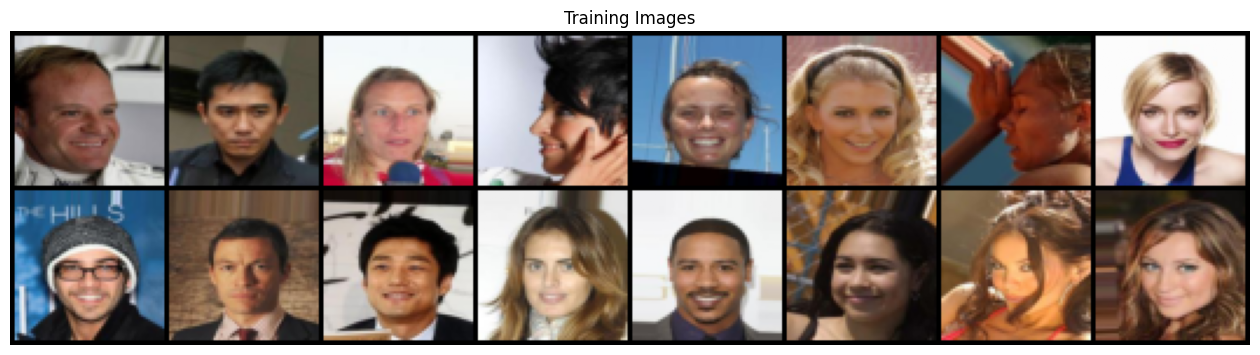

In [15]:
utils.plotDataLoader(loader)

In [ ]:
FID_list, IS_list, GEN_loss_list, DISC_loss_list = [], [], [], []
for epoch in range(NUM_EPOCHS):
    utils.startSeed(1)
    init = time.time()
    for batch_idx, real in enumerate(loader):

        real = real.to(device)
        ##TRAIN Discriminator

        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator: min -E[critic(gen_fake)]
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            with torch.no_grad():
                fake = gen(fixed_noise)

                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize = True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize = True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            utils.appendImagesToGrid(torch_utils.make_grid(fake.detach().cpu(), padding=2, normalize=True))
            step+=1
    #Save Discriminator and Generator Losses
    utils.appendLosses(loss_gen.item(), loss_critic.item())
    #Calculate FID and IS
    for i in range(10):
      with torch.no_grad():
        z = torch.randn((100, Z_DIM, 1, 1)).to(device)
        fake_imgs = gen(z)
      if i == 9:
        IS_mean, IS_std, FID = evaluator.fill_fake_image_batch(fake_imgs, True)
      else:
        evaluator.fill_fake_image_batch(fake_imgs, False)

    #Save IS and FID
    utils.appendInceptionScore(IS_mean)
    utils.apendFid(FID)

    #If last parameter is True will plot during training
    if (epoch + 1) % 5 == 0:
      precision, recall = evaluator.getPrecRecall()
      utils.appendPrecisionRecall(precision, recall)
      print("Precision: {}, Recall: {}".format(precision, recall))

    #Save Checkpoint and Obtained Results in txt
    if (epoch + 1) % 15 == 0:
      utils.save_checkpoint(epoch, gen, opt_gen, critic, opt_critic, loss_gen, loss_critic)
      utils.saveResults(epoch)

    #Clear activations of Fake Images
    evaluator.clear_fake_images()


    #Calculate Epoch Time
    end = time.time()
    epoch_time = end - init
    utils.appendEpochTime(epoch_time)

    #Print Information of the Epoch
    print(
      f"Epoch [{epoch+1}/{NUM_EPOCHS}] Time {epoch_time} Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}, Frechet Inception Distance: {FID:.4f}, Inception Score: {IS_mean:.4f}"
    )

#Print total Training Time
print("Total Training Time:", utils.getTotalTrainingTime())

#Save Results in txt
utils.saveResults(NUM_EPOCHS)


Epoch [1/50] Time 804.4085049629211 Loss D: -1.5271, loss G: 0.6957, Frechet Inception Distance: 314.1672, Inception Score: 1.4453


### Losses Chart

In [ ]:
utils.plotLossesChart()

### FID and IS Chart

In [ ]:
utils.plotFidIsChart()

### Precision and Recall Chartt

In [ ]:
utils.PrecisionRecall()

### TensorBoard

In [ ]:
#You can check the results in TensorBoard
%tensorboard --logdir logs

### Here you can generate Fake Images

In [ ]:
utils.getGeneratedImage(gen)

### Save *Generator* Model

In [ ]:
utils.saveFinalModel(gen)

### Here you can save a grid animation of the fake images

In [ ]:
author = "Sergi Sanchez Hernandez"
utils.grid_animation(author)


### Here you can generate and create Fake Images

In [ ]:
#num_images < 129
utils.saveNImages(gen, 15)